In [ ]:
import cupy as cp
import matplotlib.pyplot as plt

# CUDA kernel for the Jacobi iteration.
jacobi_kernel = cp.RawKernel(r'''
extern "C" __global__
void jacobi_kernel(const float * U, float * U_new, int n)
{
    int i = blockDim.y * blockIdx.y + threadIdx.y + 1; // 1 offset for boundary.
    int j = blockDim.x * blockIdx.x + threadIdx.x + 1; // 1 offset for boundary.

    if (i < n - 1 && j < n - 1) // 1 offset for boundary.
      {
        U_new[i * n + j] = 0.25 * (U[(i - 1) * n + j] + U[(i + 1) * n + j] +
                                   U[i * n + (j - 1)] + U[i * n + (j + 1)]);
      }
}
''', 'jacobi_kernel')

jacobi_kernel.compile()

# Initialize the matrix with boundary conditions using CuPy.
def initialize_matrix(n):
    U = cp.zeros((n, n), dtype=cp.float32)
    U[0, :] = 1  # Top boundary.
    U[-1, :] = 10  # Bottom boundary.
    U[:, 0] = 1  # Left boundary.
    U[:, -1] = 1  # Right boundary.
    return U

Convergence reached after 24460 iterations.


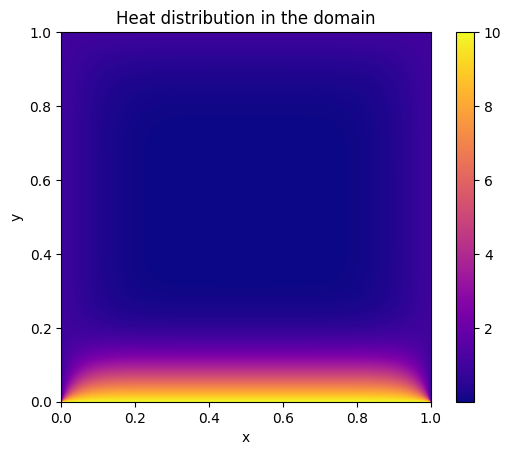

In [ ]:
def main():
    n = 1024  # Grid size.
    tol = 1e-4  # Convergence tolerance.
    max_iter = int(1e5)  # Maximum number of iterations.

    U = initialize_matrix(n)
    U_new = U

    threads_per_block = (16, 16)
    blocks_per_grid = ((n - 2) // threads_per_block[0] + 1, (n - 2) // threads_per_block[1] + 1)

    for iteration in range(max_iter):
        jacobi_kernel((blocks_per_grid), (threads_per_block), (U, U_new, n))  # Kernel launch.

        # Convergence check.
        diff = cp.max(cp.abs(U_new - U))
        if diff < tol:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break

        U[:] = U_new[:] # Update the matrix.

    # Transfer final result back to host.
    U_host = U.get()

    # Plotting the result.
    plt.imshow(U_host, cmap='plasma', extent=[0, 1, 0, 1])
    plt.colorbar()
    plt.title('Heat distribution in the domain')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

if __name__ == "__main__":
    main()